In [1]:
# def setup(basedir=None):
#     if basedir == None:
#         basedir: str = r"/media/kats/DocumentData/Data/data_depth_selection/"

#     #             basedir = "/media/michaelkatsoulis/Data raw/Datasets/KITTI_cvlibs/"
#     date = "2011_09_26"
#     #     drive = "0001"
#     drive = "0113"
#     return pykitti.raw(basedir, date, drive)

In [2]:
# This is a sample Python script.

# Press Shift+F10 to execute it or replace it with your code.
# Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.
import google.protobuf
# from bagpy import bagreader
# import bagpy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams["figure.figsize"] = (15,7)
from mpl_toolkits.axes_grid1 import make_axes_locatable

# import pandas as pd
import sys
import importlib
# importlib.reload(ImagePointSelector)


import rosbag
from sensor_msgs.msg import Image


import cv2

In [3]:
sys.path.insert(0, '/home/kats/Documents/Repos/aru-core/build/lib')
import aru_py_mesh

In [4]:
sys.path.append('../Modular files/')
import ImagePointSelector
import ImgFeatureExtactorModule
import DatasetHandler


Imported cv2
Imported numpy as np
Imported cv2
Imported numpy as np


In [5]:
# importlib.reload(DatasetHandler)
# importlib.reload(ImgFeatureExtactorModule)

## Change this to enable outputs:

In [6]:
outputs=False

#  Functions


In [7]:
def get_error_map(dense_map_1, dense_map_2, mask = False, thresh = 0):
    if mask:
        error_map = dense_map_1 - dense_map_2
    else:
        mask = ~(np.isnan(dense_map_1)*np.isnan(dense_map_2))
        mask = np.array(mask, dtype='float')
        mask[mask == 0] = np.nan
        
        dense_map_1[np.isnan(dense_map_1)] = 0
        dense_map_2[np.isnan(dense_map_2)] = 0
        error_map = dense_map_1 - dense_map_2
        error_map = error_map*mask
    return error_map.copy()

def get_dense_depth(sparse, mask = False, thresh = 0):
    dense_depth = depth_est.create_dense_depth(sparse_depth)[1]
    if mask:
        dense_depth[dense_depth<thresh] = np.nan
    return dense_depth

def nan_threshold_im(image, threshold=0, method = 'le'):
    r""" Sets all below threshold to nan"""
    img = np.array(image, dtype='float')
    if method.lower() =='l':
        img[img<threshold] = np.nan
#     elif method.lower() == 'leq':
    else:
        img[img<=threshold] = np.nan
        
    return img


def normalise(with_nans, scalar = 255, dtype = np.uint8, decimals = 0):
    nans = np.isnan(with_nans)
    
    tmp = with_nans[~nans]
    tmp = np.round(((tmp + np.min(tmp))/(np.abs(np.min(tmp))+np.abs(np.max(tmp))))*scalar, decimals).astype(dtype)
        
    normalised = with_nans.copy()
    normalised[~nans] = tmp
    
    return normalised

In [8]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), "valid") / w


def render_points(points, img_shape=[375, 1242], normalise=False, NanType = False, dilation_size=1, colour_map=-1, verbose = False):
    valid = np.where(
        (points[:, 0] >= 0) & (points[:, 1] >= 0) & (points[:, 0] < img_shape[1]) & (points[:, 1] < img_shape[0])
    )
    if verbose: print("Rejecting", len(valid), " points")
    img_shape = np.array(img_shape).reshape((-1))
    #     img_shape[:2] += 1

    if colour_map != -1:
        points = points[valid].round().astype(int)
        
        #         print("Using cmap")
        if len(img_shape) < 3:
            img_shape = np.hstack((img_shape, 3))
        rendered = np.zeros(img_shape, dtype=np.uint8)

        minima = min(points[:, 2])
        maxima = max(points[:, 2])

        norm = colors.Normalize(vmin=minima, vmax=maxima, clip=True)
        mapper = cm.ScalarMappable(norm=norm, cmap=colour_map)
        cs = mapper.to_rgba(points[:, 2])[:, :3] * 255

        rendered[points[:, 1].astype(int), points[:, 0].astype(int)] = cs
        rendered = cv2.dilate(rendered, np.ones((dilation_size, dilation_size)))
        
        return rendered

    else:
        if len(img_shape) > 2:
            img_shape = img_shape[:2]

        rendered = np.zeros(np.array(img_shape))
        rendered[points[:, 1].astype(int), points[:, 0].astype(int)] = points[:, 2]
        if dilation_size > 1:
            rendered = cv2.dilate(rendered, np.ones((dilation_size, dilation_size)))
            
        if NanType:
            rendered = np.array(rendered, dtype='float')
            rendered[rendered==0] = np.nan
        return rendered


In [9]:
def display_colour(img_gray, name="colour", legend=True):
#     img_gray = img_gray.copy() 
#     color =(img_gray.round()).astype(np.uint8)
    color = normalise(img_gray)
    fig = plt.figure()
    ax = plt.gca()
    plot = ax.imshow(color, cmap = 'plasma')
    if legend: 
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(plot, cax=cax)
        
    ax.set_title(name)
    plt.show()
    
    pass
    

In [10]:
Handler = DatasetHandler.Dataset_Handler_Depth_Data('/media/kats/DocumentData/Data/data_depth_selection/depth_selection/')
depth_est = aru_py_mesh.PyDepth("/home/kats/Documents/Repos/aru-core/src/mesh/config/mesh_depth.yaml")

# Handler.reset_frames()

I20210930 20:49:46.711520 11025 mesh.cpp:79] Camera params found


In [11]:
# plt.imshow(sparse_depth)


In [12]:
np.shape(dense_depth)

NameError: name 'dense_depth' is not defined

In [ ]:
sparse_depth = np.single(next(Handler.depth))
sparse_depth2 =np.single( next(Handler.depth))

if len(np.shape(sparse_depth)) ==3:
    sparse_depth =  np.single(cv2.cvtColor(sparse_depth, cv2.COLOR_BGR2GRAY))
    sparse_depth2 =  np.single(cv2.cvtColor(sparse_depth2, cv2.COLOR_BGR2GRAY))
    
sparse_depth = nan_threshold_im(sparse_depth, method = 'leq')
sparse_depth2 = nan_threshold_im(sparse_depth2, method = 'leq')


print("Sparse depth of type:", sparse_depth.dtype)
print(f"Shapes of inputs are:\n\tImg - {Handler.first_image_left.shape}\n\tDepth - {sparse_depth.shape}")

# Make sure sparse_depth is float
depth_est = aru_py_mesh.PyDepth("/home/kats/Documents/Repos/aru-core/src/mesh/config/mesh_depth.yaml")
dense_colour, dense_depth = depth_est.create_dense_depth(sparse_depth)
dense_depth = nan_threshold_im(dense_depth)

dense_colour2, dense_depth2 = depth_est.create_dense_depth(sparse_depth2)
dense_depth2 = nan_threshold_im(dense_depth2)
error = get_error_map(dense_depth, dense_depth2, mask = True)

print("Size of dense depth: ", dense_depth.shape)
display_colour(sparse_depth.copy(), "Sparse")
display_colour(dense_depth.copy(), "Dense")
display_colour(error, 'Error')




# cv2.imshow("Error", get_error_map(dense_depth, dense_depth2))
# cv2.waitKey(3000)

# Error in sparser meshes

In [ ]:
def subsample_sparse(sparse_img, num_points = 500, threshold = 0, verbose=False): 

    tmp = np.array(np.where(sparse_img>0)).T
    tmp = np.stack((tmp[:,1], tmp[:,0], sparse_img[tmp[:,0], tmp[:,1]])).T
    sampling_rate = tmp.shape[0]//num_points
    if verbose:
        print(f"Decimating from {tmp.shape[0]} samples to {tmp.shape[0]//sampling_rate}")
    tmp = tmp[::sampling_rate,:]
    
    new_im = np.zeros(sparse_img.shape)
    new_im[tmp[:,1].astype(int), tmp[:,0].astype(int)] = tmp[:,2]
    return new_im

def random_sample(sparse_img, num_points = 500, threshold = 0, verbose=False): 
    
    tmp = np.array(np.where(sparse_img>0)).T
    tmp = np.stack((tmp[:,1], tmp[:,0], sparse_img[tmp[:,0], tmp[:,1]])).T

    tmp = tmp[np.random.choice(np.arange(tmp.shape[0]), size=500), :]
    new_im = np.zeros(sparse_img.shape)
    new_im[tmp[:,1].astype(int), tmp[:,0].astype(int)] = tmp[:,2]
    return new_im


In [ ]:
# sparse_depth.shape
# idxs = np.array(np.where(sparse_depth>0)).T
# depth_pts = sparse_depth[idxs[:,0], idxs[:,1]].copy()

# d_factor = 30
# ssp_idx = idxs[::d_factor,:]
# ssp_depth = sparse_depth.copy()[ssp_idx[:,0], ssp_idx[:,1]]

# ssp_pts = np.stack((ssp_idx[:,1], ssp_idx[:,0], ssp_depth)).T
# sparse_sparse_depth = render_points(ssp_pts, img_shape=[Handler.imheight, Handler.imwidth], NanType=True)

# plt.imshow(cv2.dilate(sparse_depth.astype(np.uint8), np.ones((2,2))))
# # plt.imshow(sparse_depth)
# plt.title(f"Sparse Depth with {np.sum(~np.isnan(sparse_depth))} pts")
# plt.show()
# # render_points(ssp_pts,  dilation_size=1)
# # plt.imshow(cv2.dilate(sparse_sparse_depth, np.ones((2,2))))
# plt.imshow(render_points(ssp_pts, img_shape=[Handler.imheight, Handler.imwidth], dilation_size=3, NanType=True))
# plt.title(f"Sparser Depth with reduction by { d_factor} times & {np.sum(~np.isnan(sparse_sparse_depth))} pts ")
# plt.show()

# e2 = get_error_map(nan_threshold_im(depth_est.create_dense_depth(sparse_depth)[1]),
#                    nan_threshold_im(depth_est.create_dense_depth(sparse_sparse_depth)[1]),
#                    mask=True)
# plt.imshow(e2)
# plt.title("Error Map")
# plt.show 

# display_colour(e2)


# Error using grid pooling

In [ ]:
import skimage.measure

In [ ]:
def get_all_pooling(depth_image, block_size=20, same_size = False, interpolation_method = cv2.INTER_NEAREST):
    depth_image = np.nan_to_num(depth_image.copy(), nan=-1)
    max_pool = skimage.measure.block_reduce(depth_image, (block_size, block_size), np.max)
    mean_pool = skimage.measure.block_reduce(depth_image, (block_size, block_size), np.mean)
    median_pool = skimage.measure.block_reduce(depth_image, (block_size, block_size), np.median)
    
    
    if same_size:
        max_pool = cv2.resize(max_pool, dsize = depth_image.shape[::-1], interpolation = interpolation_method)
        mean_pool = cv2.resize(mean_pool, dsize = depth_image.shape[::-1], interpolation = interpolation_method)
        median_pool = cv2.resize(median_pool, dsize = depth_image.shape[::-1], interpolation = interpolation_method)
    
    return [max_pool, mean_pool, median_pool]


def pooling_to_sparse(depth_image, max_num_ft = 500):
    r"""
    Pools an image and returns a sparse representation
    """
        
    block_size = np.ceil((depth_image.size//(max_num_ft))**(1/2)).astype(int)
    max_p, mean_p, median_p = get_all_pooling(depth_image, block_size = block_size, same_size=False)
    
    sparse_max, sparse_mean, sparse_median = np.zeros(depth_image.shape), np.zeros(depth_image.shape), np.zeros(depth_image.shape)
    
    idxs = np.array(np.where(max_p>0))
    sparse_max[idxs[0]*block_size, idxs[1]*block_size]  = max_p[idxs[0], idxs[1]]
    
    idxs = np.array(np.where(mean_p>0))
    sparse_mean[idxs[0]*block_size, idxs[1]*block_size]  = mean_p[idxs[0], idxs[1]]
    
    idxs = np.array(np.where(median_p>0))
    sparse_median[idxs[0]*block_size, idxs[1]*block_size]  = median_p[idxs[0], idxs[1]]
    
    return sparse_max, sparse_mean, sparse_median
    
def pooling_to_dense(depth_image, max_num_ft = 500):
    r"""
    Pools an image and returns a dense representation
    """
    
#     block = np.ceil((depth_image.size//(max_num_ft))**(1/2)).astype(int)
    
    
    max_p, mean_p, median_p = pooling_to_sparse(depth_image, max_num_ft=max_num_ft)
    
    _, max_p = depth_est.create_dense_depth(max_p)
    _, mean_p = depth_est.create_dense_depth(mean_p)
    _, median_p = depth_est.create_dense_depth(median_p)
    
    return max_p, mean_p, median_p
    

In [ ]:
# # max_pooling.shape[0]*20 , max_pooling.shape[1]*20
# # a, b, c = pooling_to_sparse(dense_depth.copy(), 10)
# # a, b, c = pooling_to_sparse(dense_depth.copy(), 2)
# a, b, c = pooling_to_sparse(dense_depth.copy(), 2000)
# plt.imshow(cv2.dilate(a, np.ones((4,4))))
# plt.show()
# plt.imshow(depth_est.create_dense_depth(a)[1])
# plt.show()

# a, b, c = pooling_to_sparse(dense_depth.copy(), 500)

# plt.imshow(cv2.dilate(a, np.ones((4,4))))
# plt.show()
# plt.imshow(depth_est.create_dense_depth(a)[1])
# plt.show()


In [ ]:
# max_pooling, mean_pooling, median_pooling = get_all_pooling(dense_depth, same_size=False)

# plt.imshow(dense_depth)
# plt.title("Original")
# plt.show()

# plt.imshow(max_pooling)
# plt.title("max_pool")
# plt.show()

# plt.imshow(mean_pooling)
# plt.title("mean_pool")
# plt.show()

# plt.imshow(median_pooling)
# plt.title("median_pool")
# plt.show()

# Chosing points for mesh from individual images

In [ ]:
# image=Handler.first_image_left.copy()[:dense_depth.shape[0], :dense_depth.shape[1]]

# p_depth = ImagePointSelector.image_point_selector(image, dense_depth)

# chosen_depth = render_points(p_depth, img_shape=dense_depth.shape)
# _, dense_chosen = depth_est.create_dense_depth(chosen_depth)
# dense_chosen = nan_threshold_im(dense_chosen)

# d1= nan_threshold_im(dense_depth)

# plt.imshow(dense_chosen)
# plt.title("Depth from chosen points")
# plt.show()
# plt.imshow(d1)
# plt.title("Dense Original")
# plt.show()

# e = get_error_map(d1, dense_chosen)
# plt.imshow(e, cmap = 'plasma')
# plt.title("Error plot")
# plt.show()



# # problem with logical and

In [ ]:
def keyPoints_to_uv(kps):
    uv = np.zeros((len(kps),2))
    for i in range(len(kps)):
        uv[i] = kps[i].pt
        
    return uv

def keyPoints_to_uvd(depth_img, kps):
    uv = keyPoints_to_uv(kps).round().astype(int)
    uvd = np.hstack((uv,depth_img[uv[:,1],uv[:,0]].reshape(-1,1)))
        
    return uvd


In [ ]:
orb_det = ImgFeatureExtactorModule.FeatureDetector(max_num_ft=2000)
surf_det = ImgFeatureExtactorModule.FeatureDetector(det_type='SURF', max_num_ft=2000)
sift_det = ImgFeatureExtactorModule.FeatureDetector(det_type='SIFT', max_num_ft=2000)

def get_img_feat_depths(img, depth_img, orb_detector=orb_det, surf_detector=surf_det, sift_detector=sift_det, blur_size=None, threshold=True, verbose=False, max_num_ft=500, return_kp_img=False):

    if blur_size is not None:
        blur_img = cv2.blur(img.copy(), ksize=(blur_size,blur_size))
    else:
        blur_img = img.copy()
    orb_kps = orb_detector.detect(blur_img)
    surf_kps = surf_detector.detect(blur_img)[:max_num_ft]
    sift_kps = sift_detector.detect(blur_img)
    _, orb_depth = depth_est.create_dense_depth(render_points(keyPoints_to_uvd(depth_img, orb_kps), img_shape=img.shape, NanType=True))
    _, surf_depth =depth_est.create_dense_depth(render_points(keyPoints_to_uvd(depth_img, surf_kps), img_shape=img.shape, NanType=True))
    _, sift_depth =depth_est.create_dense_depth(render_points(keyPoints_to_uvd(depth_img, sift_kps), img_shape=img.shape, NanType=True))
    
    if threshold:
        orb_depth = nan_threshold_im(orb_depth)
        sift_depth = nan_threshold_im(sift_depth)
        surf_depth = nan_threshold_im(surf_depth)
    if verbose:
        print("Number of orb keypoints detected:\t",len(orb_kps))
        print("Number of surf keypoints detected:\t",len(sift_kps))
        print("Number of sift keypoints detected:\t",len(surf_kps))
        
    if return_kp_img:
        kp_img_orb = np.zeros(img.shape)
        kp_img_surf = np.zeros(img.shape)
        kp_img_sift = np.zeros(img.shape)
        kp_img_orb = cv2.drawKeypoints(img, keypoints = orb_kps, outImage=kp_img_orb)
        kp_img_surf = cv2.drawKeypoints(img, keypoints = surf_kps, outImage=kp_img_surf)
        kp_img_sift = cv2.drawKeypoints(img, keypoints = sift_kps, outImage=kp_img_sift)
        
        return orb_depth, surf_depth, sift_depth, kp_img_orb, kp_img_sift, kp_img_surf
        
    
    return [orb_depth, surf_depth, sift_depth]

In [ ]:
# for i in range(10):
#     image = next(Handler.left_image)
#     orb_depth, surf_depth, sift_depth, img_orb, img_surf, img_sift = get_img_feat_depths(image, dense_depth, orb_det, surf_det, sift_det, return_kp_img=True, verbose=True)

# # plt.imshow(dense_depth)
# # plt.title('dense_depth')
# # plt.show()


# # plt.imshow(orb_depth)
# # plt.title('orb_depth')
# # plt.show()
# # plt.imshow(img_orb)
# # plt.title('img_orb')
# # plt.show()

# # plt.imshow(surf_depth)
# # plt.title('surf_depth')
# # plt.show()
# # plt.imshow(img_surf)
# # plt.title('img_surf')
# # plt.show()

# # plt.imshow(sift_depth)
# # plt.title('sift_depth')
# # plt.show()
# # plt.imshow(img_sift)
# # plt.title('img_sift')
# # plt.show()






# # print("number of orb keypoints: ", len(kps))
# # new = np.ones(image.shape)
# # # plt.imshow(cv2.drawKeypoints(blur_img.copy()*(~np.isnan(dense_depth)), keypoints = orb_kps, outImage=new ))
# # plt.imshow(cv2.drawKeypoints(image, keypoints = orb_kps, outImage=new ))
# # plt.show()
# # plt.imshow(orb_depth)
# # plt.show()


# # new = np.ones(image.shape)
# # # plt.imshow(cv2.drawKeypoints(blur_img.copy()*(~np.isnan(dense_depth)), keypoints = surf_kps, outImage=new ))
# # plt.imshow(cv2.drawKeypoints(image, keypoints = surf_kps, outImage=new ))
# # plt.show()
# # plt.imshow(surf_depth)
# # plt.show()

# # new = np.ones(image.shape)
# # # plt.imshow(cv2.drawKeypoints(blur_img.copy()*(~np.isnan(dense_depth)), keypoints = sift_kps, outImage=new ))
# # plt.imshow(cv2.drawKeypoints(image, keypoints = sift_kps, outImage=new ))
# # plt.show()
# # plt.imshow(sift_depth)
# # plt.show()

# # plt.imshow(~np.isnan(dense_depth))
# # plt.show()

# Maximum of curvature:

$k = f_y^2 f_{xx} - 2f_{x}f_{y}f_{xy} + f_x^2f_{yy}$


In [ ]:
if outputs: 
    tmp= img.copy()
    plt.imshow(tmp)

In [ ]:
def maximumOfCurvature(
    bw_img,
    ft_det="sift",
    max_num_pts=2000,
    verbose=False,
    return_img=False,
    return_kps=False,
):
    r"""
    Returns features thresholded close to to max_num_pts.
    Return format: (u,v) x n fts
    """

    tmp = bw_img.copy()

    fx = cv2.Sobel(tmp, cv2.CV_8U, 1, 0)
    fxx = cv2.Sobel(fx, cv2.CV_8U, 1, 0)
    fy = cv2.Sobel(tmp, cv2.CV_8U, 0, 1)
    fyy = cv2.Sobel(fy, cv2.CV_8U, 0, 1)
    fxy = cv2.Sobel(tmp, cv2.CV_8U, 1, 1)

    k = (fy ** 2) * fxx - 2 * fx * fy * fxy + (fx ** 2) * fyy

    if ft_det.lower() == "threshold":
        vals, unique_nums = np.unique(k.flatten(), return_counts=True)
        target_pts = 2000
        thresh = 255
        for i in range(1, len(unique_nums)):
            tot = np.sum(unique_nums[-i:])
            if tot > target_pts:
                if verbose:
                    print(f"Took {i} vals, got {tot} total")
                thresh = vals[-i]
                break
        fts = np.array(np.where(k >= thresh))[::-1, :]
    elif ft_det.lower() == "sift":
        kps = sift_det.detect(k)
        fts = np.zeros((len(kps), 2), dtype=int)
        for j, kp in enumerate(kps):
            fts[j] = np.round(kp.pt)
        fts = fts.T
    elif ft_det.lower() == "surf":
        kps = surf_det.detect(k)
        fts = np.zeros((len(kps), 2), dtype=int)
        for j, kp in enumerate(kps):
            fts[j] = np.round(kp.pt)
        fts = fts.T
        
    elif ft_det.lower() == "orb":
        kps = orb_det.detect(k)
        fts = np.zeros((len(kps), 2), dtype=int)
        for j, kp in enumerate(kps):
            fts[j] = np.round(kp.pt)
        fts = fts.T
    if return_img:
        if return_kps and (ft_det.lower()!='threshold'):
            return kps, k
        return fts, k
    return fts


def MoCToDenseDepth(depth_map, MoC, verbose=False):
    new_sparse = -np.ones(depth_map.shape)
    new_sparse[MoC[1, :], MoC[0, :]] = depth_map[MoC[1, :], MoC[0, :]]
    return depth_est.create_dense_depth(new_sparse)[1]


if outputs:
    maximumOfCurvature(Handler.first_image_left, verbose=True)

# Video maker

In [ ]:
from ipywidgets import Video, Image
from IPython.display import Video
import base64


In [ ]:
# width = Handler.first_image_left.shape[1]
# height = Handler.first_image_left.shape[0]
# FPS = 5
# # seconds = 10
# frames = 100 #len(Handler.left_image_files)[:100]

# fourcc = cv2.VideoWriter_fourcc(*"MP42")
# video_orb = cv2.VideoWriter("./tmp.mp4", fourcc, float(FPS), (width, height))

# print("Starting:\n")

# for i in range(frames):
#     img = next(Handler.left_image)
#     kps = orb_det.detect(img)
    
#     frame = img.copy()
#     frame = cv2.drawKeypoints(img.copy(), keypoints = kps, outImage=tmp)
#     frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # np.random.randint(0, 256, (height, width, 3), dtype=np.uint8)
#     video_orb.write(frame)
#     print(".", end="")
    
# video_orb.release()
# print("Done")

In [ ]:
# player = Video.from_file("./tmp.mp4")
# player

# Error Metrics

In [ ]:
def get_MSE(error_img, normalise_by__num_pixels = True, threshold=0, verbose=False):
    r"""Returns the MSE error for the error image"""
    this_e = error_img[~np.isnan(error_img)].copy()
    this_e = this_e**2
    mse = np.mean(this_e)
    if verbose: print("MSE is:", mse)
    if normalise_by__num_pixels:
        mse = mse/(np.sum(error_img[~np.isnan(error_img)]>threshold))
    return mse
# get_MSE(e)

# Error for all over dataset

## Steps for getting error accross dataset:

- Init Datahandler class
- Load in next image
    - 1. Dense
    - 2. Nan outside
   
- Get all features 
    - Image
    - Pooling
    - Random
    - Subsample Sparse

- Get dense maps
- Get error map
- Write video frame
- get MSE 




    

In [ ]:
def contrasting(bland, max_increase=2):
    tmp=bland.copy()
    tmp = np.abs(tmp)
    factor = 255/(abs(np.nanmax(tmp))+abs(np.nanmin(tmp)))
    if factor>max_increase:
        factor = max_increase
    tmp *= factor
#     tmp+=abs(np.nanmin(tmp))
    tmp = tmp.round().astype(np.uint8)
    
    return tmp

def mask_out(full_im, mask_im, uint8=True):
#     mask_im = nan_threshold_im(mask_im)
    mask = ~np.isnan(mask_im)
    mask = mask.astype(np.uint8)
    if len(full_im.shape)==3:
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    
    if uint8:
        return (full_im*mask).astype(np.uint8)
    return full_im*mask

In [ ]:
def plot_moc_cicles(image, moc_pts, radius = 3, color=(255, 100, 0), thickness =2):
    image = image.copy()
    if len(image.shape) !=3:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for vu in moc_pts.T:
#         print(pt)
        image = cv2.circle(image, (vu[0], vu[1]), radius, color, thickness)
    return image

In [ ]:
def save_moc():
    fig, ax = plt.subplots(3,2, figsize=[26,13])
    fig.tight_layout(pad=3)
    fig.subplots_adjust(top=0.9)

    fig.suptitle(f"Maximum of Curvature -- MSE:{np.round(e_moc[i], 6)}",fontsize = 20, weight = 'medium')

    ax[0,0].imshow(img, 'gray', aspect="auto")
    ax[0,0].set_title("Image")
    ax[0,0].axis('off')

    ax[0,1].imshow(moc_c, aspect="auto", cmap=cm.jet)
    ax[0,1].set_title("MOC Pts")
    ax[0,1].axis('off')


    ax[1,1].imshow(moc_depth, aspect="auto", cmap=cm.jet)
    ax[1,1].set_title("MOC Depth")
    ax[1,1].axis('off')

    ax[1,0].imshow(e_img_moc, aspect="auto", cmap=cm.jet)
    ax[1,0].set_title("Error plot")
    ax[1,0].axis('off')


    ax[2,0].imshow(dense, aspect="auto", cmap=cm.jet)
    ax[2,0].set_title("Ground Truth")
    ax[2,0].axis('off')

    w=np.round((i/10)).astype(int)
#     ax[2,1].plot(e_sparser[:i+1], '-.', label = "e sparser")
    ax[2,1].plot(e_random[:i+1], '-.', label = "e random")
    ax[2,1].plot(e_orb[:i+1], label = "e orb")
    ax[2,1].plot(e_surf[:i+1], label = "e surf")
    ax[2,1].plot(e_sift[:i+1], label = "e sift")
    ax[2,1].plot(e_max_p[:i+1], '--', label = "e max pool")
#     ax[2,1].plot(e_mean_p[:i+1], '--', label = "e mean pool")
#     ax[2,1].plot(e_median_p[:i+1], '--', label = "e median pool")
    ax[2,1].plot(e_moc[:i+1], '-o', label="e MoC")
    ax[2,1].text(i, e_moc[i], f'MSE:{np.round(e_moc[i], 6)}')

    ax[2,1].legend()
    ax[2,1].set_title("Errors by sampling per frame")
    ax[2,1].set_xlabel("Frame #")
    ax[2,1].set_ylabel("MSE")
    # plt.show()
    fig.savefig("./tmp_MoC.png")
    
    plt.close('all')
    
    
def save_orb():
    fig, ax = plt.subplots(3,2, figsize=[26,13])
    fig.tight_layout(pad=3)
    fig.subplots_adjust(top=0.9)

    fig.suptitle(f"ORB Detector -- MSE:{np.round(e_orb[i], 6)}",fontsize = 20, weight = 'medium')

    ax[0,0].imshow(img, 'gray', aspect="auto")
    ax[0,0].set_title("Image")
    ax[0,0].axis('off')

    ax[0,1].imshow(img_orb, aspect="auto", cmap=cm.jet)
    ax[0,1].set_title("ORB Pts")
    ax[0,1].axis('off')


    ax[1,1].imshow(orb_depth, aspect="auto", cmap=cm.jet)
    ax[1,1].set_title("ORB Depth")
    ax[1,1].axis('off')

    ax[1,0].imshow(e_img_orb, aspect="auto", cmap=cm.jet)
    ax[1,0].set_title("Error plot")
    ax[1,0].axis('off')


    ax[2,0].imshow(dense, aspect="auto", cmap=cm.jet)
    ax[2,0].set_title("Ground Truth")
    ax[2,0].axis('off')

    w=np.round((i/10)).astype(int)
#     ax[2,1].plot(e_sparser[:i+1], '-.', label = "e sparser")
    ax[2,1].plot(e_random[:i+1], '-.', label = "e random")
    ax[2,1].plot(e_orb[:i+1], '-o', label = "e orb")
    ax[2,1].plot(e_surf[:i+1], label = "e surf")
    ax[2,1].plot(e_sift[:i+1], label = "e sift")
    ax[2,1].plot(e_max_p[:i+1], '--', label = "e max pool")
#     ax[2,1].plot(e_mean_p[:i+1], '--', label = "e mean pool")
#     ax[2,1].plot(e_median_p[:i+1], '--', label = "e median pool")
    ax[2,1].plot(e_moc[:i+1], '--', label="e MoC")
    
    
    ax[2,1].text(i, e_orb[i], f'MSE:{np.round(e_orb[i], 6)}')

    ax[2,1].legend()
    ax[2,1].set_title("Errors by sampling per frame")
    ax[2,1].set_xlabel("Frame #")
    ax[2,1].set_ylabel("MSE")
    # plt.show()
    fig.savefig("./tmp_ORB.png")
    
    plt.close('all')
    


    
def save_sift():
    fig, ax = plt.subplots(3,2, figsize=[26,13])
    fig.tight_layout(pad=3)
    fig.subplots_adjust(top=0.9)

    fig.suptitle(f"SIFT Detector -- MSE:{np.round(e_sift[i], 6)}",fontsize = 20, weight = 'medium')

    ax[0,0].imshow(img, 'gray', aspect="auto")
    ax[0,0].set_title("Image")
    ax[0,0].axis('off')

    ax[0,1].imshow(img_sift, aspect="auto", cmap=cm.jet)
    ax[0,1].set_title("SIFT Pts")
    ax[0,1].axis('off')


    ax[1,1].imshow(sift_depth, aspect="auto", cmap=cm.jet)
    ax[1,1].set_title("SIFT Depth")
    ax[1,1].axis('off')

    ax[1,0].imshow(e_img_sift, aspect="auto", cmap=cm.jet)
    ax[1,0].set_title("Error plot")
    ax[1,0].axis('off')


    ax[2,0].imshow(dense, aspect="auto", cmap=cm.jet)
    ax[2,0].set_title("Ground Truth")
    ax[2,0].axis('off')

    w=np.round((i/10)).astype(int)
#     ax[2,1].plot(e_sparser[:i+1], '-.', label = "e sparser")
    ax[2,1].plot(e_random[:i+1], '-.', label = "e random")
    ax[2,1].plot(e_orb[:i+1], label = "e orb")
    ax[2,1].plot(e_surf[:i+1], label = "e surf")
    ax[2,1].plot(e_sift[:i+1], '-o', label = "e sift")
    ax[2,1].plot(e_max_p[:i+1], '--', label = "e max pool")
#     ax[2,1].plot(e_mean_p[:i+1], '--', label = "e mean pool")
#     ax[2,1].plot(e_median_p[:i+1], '--', label = "e median pool")
    ax[2,1].plot(e_moc[:i+1], '--', label="e MoC")
    
    
    ax[2,1].text(i, e_sift[i], f'MSE:{np.round(e_sift[i], 6)}')

    ax[2,1].legend()
    ax[2,1].set_title("Errors by sampling per frame")
    ax[2,1].set_xlabel("Frame #")
    ax[2,1].set_ylabel("MSE")
    # plt.show()
    fig.savefig("./tmp_SIFT.png")
    
    plt.close('all')
    
    


    
def save_surf():
    fig, ax = plt.subplots(3,2, figsize=[26,13])
    fig.tight_layout(pad=3)
    fig.subplots_adjust(top=0.9)

    fig.suptitle(f"SURF Detector -- MSE:{np.round(e_surf[i], 6)}",fontsize = 20, weight = 'medium')

    ax[0,0].imshow(img, 'gray', aspect="auto")
    ax[0,0].set_title("Image")
    ax[0,0].axis('off')

    ax[0,1].imshow(img_surf, aspect="auto", cmap=cm.jet)
    ax[0,1].set_title("SURF Pts")
    ax[0,1].axis('off')


    ax[1,1].imshow(surf_depth, aspect="auto", cmap=cm.jet)
    ax[1,1].set_title("SURF Depth")
    ax[1,1].axis('off')

    ax[1,0].imshow(e_img_surf, aspect="auto", cmap=cm.jet)
    ax[1,0].set_title("Error plot")
    ax[1,0].axis('off')


    ax[2,0].imshow(dense, aspect="auto", cmap=cm.jet)
    ax[2,0].set_title("Ground Truth")
    ax[2,0].axis('off')

    w=np.round((i/10)).astype(int)
#     ax[2,1].plot(e_sparser[:i+1], '-.', label = "e sparser")
    ax[2,1].plot(e_random[:i+1], '-.', label = "e random")
    ax[2,1].plot(e_orb[:i+1], label = "e orb")
    ax[2,1].plot(e_sift[:i+1], label = "e sift")
    ax[2,1].plot(e_surf[:i+1], '-o', label = "e surf")
    ax[2,1].plot(e_max_p[:i+1], '--', label = "e max pool")
#     ax[2,1].plot(e_mean_p[:i+1], '--', label = "e mean pool")
#     ax[2,1].plot(e_median_p[:i+1], '--', label = "e median pool")
    ax[2,1].plot(e_moc[:i+1], '--', label="e MoC")
    
    
    ax[2,1].text(i, e_surf[i], f'MSE:{np.round(e_surf[i], 6)}')

    ax[2,1].legend()
    ax[2,1].set_title("Errors by sampling per frame")
    ax[2,1].set_xlabel("Frame #")
    ax[2,1].set_ylabel("MSE")
    # plt.show()
    fig.savefig("./tmp_SURF.png")
    
    plt.close('all')
    

def save_max_pool():
    fig, ax = plt.subplots(3,2, figsize=[26,13])
    fig.tight_layout(pad=3)
    fig.subplots_adjust(top=0.9)

    fig.suptitle(f"Max Pooling -- MSE:{np.round(e_max_p[i], 6)}",fontsize = 20, weight = 'medium')

    ax[0,0].imshow(img, 'gray', aspect="auto")
    ax[0,0].set_title("Image")
    ax[0,0].axis('off')

    ax[0,1].imshow(max_pool, aspect="auto", cmap=cm.jet)
    ax[0,1].set_title("Max Pooling Pts")
    ax[0,1].axis('off')


    ax[1,1].imshow(max_pool, aspect="auto", cmap=cm.jet)
    ax[1,1].set_title("Max Pooling Depth")
    ax[1,1].axis('off')

    ax[1,0].imshow(e_img_max_p, aspect="auto", cmap=cm.jet)
    ax[1,0].set_title("Error plot")
    ax[1,0].axis('off')


    ax[2,0].imshow(dense, aspect="auto", cmap=cm.jet)
    ax[2,0].set_title("Ground Truth")
    ax[2,0].axis('off')

    w=np.round((i/10)).astype(int)
#     ax[2,1].plot(e_sparser[:i+1], '-.', label = "e sparser")
    ax[2,1].plot(e_random[:i+1], '-.', label = "e random")
    ax[2,1].plot(e_orb[:i+1], label = "e orb")
    ax[2,1].plot(e_sift[:i+1], label = "e sift")
    ax[2,1].plot(e_surf[:i+1], '--', label = "e surf")
    ax[2,1].plot(e_max_p[:i+1], '-o', label = "e max pool")
#     ax[2,1].plot(e_mean_p[:i+1], '--', label = "e mean pool")
#     ax[2,1].plot(e_median_p[:i+1], '--', label = "e median pool")
    ax[2,1].plot(e_moc[:i+1], '--', label="e MoC")
    
    
    ax[2,1].text(i, e_max_p[i], f'MSE:{np.round(e_max_p[i], 6)}')

    ax[2,1].legend()
    ax[2,1].set_title("Errors by sampling per frame")
    ax[2,1].set_xlabel("Frame #")
    ax[2,1].set_ylabel("MSE")
    # plt.show()
    fig.savefig("./tmp_Max_P.png")
    
    plt.close('all')
        

In [ ]:
from tqdm.notebook import tqdm, trange
import time  


In [ ]:
depth_est = aru_py_mesh.PyDepth("/home/kats/Documents/Repos/aru-core/src/mesh/config/mesh_depth.yaml")



In [1]:
Handler.reset_frames()
image = Handler.first_image_left
verbose = False


# width = Handler.first_image_left.shape[1]
# height = Handler.first_image_left.shape[0]

tmp = cv2.imread("tmp_MoC.png")
width = tmp.shape[1]
height = tmp.shape[0]


FPS = 1
skip_frames = 20
# seconds = 10
frames = 500  # len(Handler.left_image_files)[:100]
write_video = True


e_sparser = -np.ones(frames)
e_random = -np.ones(frames)
e_orb = -np.ones(frames)
e_surf = -np.ones(frames)
e_sift = -np.ones(frames)
e_max_p = -np.ones(frames)
e_mean_p = -np.ones(frames)
e_median_p = -np.ones(frames)
e_moc = -np.ones(frames)


num_ft = 2000

orb_det = ImgFeatureExtactorModule.FeatureDetector(max_num_ft=num_ft)
surf_det = ImgFeatureExtactorModule.FeatureDetector(det_type="SURF", max_num_ft=num_ft)
sift_det = ImgFeatureExtactorModule.FeatureDetector(det_type="SIFT", max_num_ft=num_ft)


if write_video:
    fourcc = cv2.VideoWriter_fourcc(*"MP42")
    video_orb = cv2.VideoWriter(
        f"/home/kats/Videos/Masters/FeatureWork/video_orb_HC_{frames}frames.mp4",
        fourcc,
        float(FPS),
        (width, height),
    )
    video_surf = cv2.VideoWriter(
        f"/home/kats/Videos/Masters/FeatureWork/video_surf_HC_{frames}frames.mp4",
        fourcc,
        float(FPS),
        (width, height),
    )
    video_sift = cv2.VideoWriter(
        f"/home/kats/Videos/Masters/FeatureWork/video_sift_HC_{frames}frames.mp4",
        fourcc,
        float(FPS),
        (width, height),
    )
    video_max_pool = cv2.VideoWriter(
        f"/home/kats/Videos/Masters/FeatureWork/video_max_pool_HC_{frames}frames.mp4",
        fourcc,
        float(FPS),
        (width, height),
    )

    video_moc = cv2.VideoWriter(f"/home/kats/Videos/Masters/FeatureWork/video_moc_HC_{frames}frames.mp4", fourcc, float(FPS), (width, height))


# video_img = cv2.VideoWriter("/home/kats/Videos/Masters/FeatureWork/video_img.mp4", cv2.VideoWriter_fourcc(*"MP42"), float(FPS), (width, height))
# video_orb_ft = cv2.VideoWriter("/home/kats/Videos/Masters/FeatureWork/video_orb_ft.mp4", fourcc, float(FPS), (width, height))
# video_surf_ft = cv2.VideoWriter("/home/kats/Videos/Masters/FeatureWork/video_surf_ft.mp4", fourcc, float(FPS), (width, height))
# video_sift_ft = cv2.VideoWriter("/home/kats/Videos/Masters/FeatureWork/video_sift_ft.mp4", fourcc, float(FPS), (width, height))


print("Starting:\n")

for i in trange(frames):
    sparse = next(Handler.depth)
    img = next(Handler.left_image)

    # Creating dense depth
    dense_colour, dense = depth_est.create_dense_depth(sparse)

    # Thresholding
    sparse = nan_threshold_im(sparse)
    dense = nan_threshold_im(dense)

    # Image Feature base depths:
    #     orb_depth, surf_depth, sift_depth = get_img_feat_depths(image, dense, orb_det, surf_det, sift_det)
    (
        orb_depth,
        surf_depth,
        sift_depth,
        img_orb,
        img_surf,
        img_sift,
    ) = get_img_feat_depths(
        img,
        dense,
        orb_det,
        surf_det,
        sift_det,
        return_kp_img=True,
        max_num_ft=num_ft,
        verbose=verbose,
    )

    # Grid based depth
    max_pool, mean_pool, median_pool = pooling_to_dense(dense, max_num_ft=num_ft)

    # Decimating
    sparser = subsample_sparse(sparse, num_points=num_ft)
    _, sparser_depth = depth_est.create_dense_depth(sparser)
    sparser_depth = nan_threshold_im(sparser_depth)
    #     need to now make the error from this
    _,random_depth = depth_est.create_dense_depth(random_sample(sparse, num_points=num_ft))
    random_depth = nan_threshold_im(random_depth)

    moc = maximumOfCurvature(img, ft_det='threshold')
    moc_depth = MoCToDenseDepth(dense, moc)

    # Geting Error maps
    e_img_orb = get_error_map(dense, orb_depth, mask=True)
    e_img_surf = get_error_map(dense, surf_depth, mask=True)
    e_img_sift = get_error_map(dense, sift_depth, mask=True)

    e_img_max_p = get_error_map(dense, max_pool, mask=True)
    e_img_mean_p = get_error_map(dense, median_pool, mask=True)
    e_img_median_p = get_error_map(dense, median_pool, mask=True)

    e_img_moc = get_error_map(dense, moc_depth, mask=True)

    # Convert to MSE
    e_sparser[i] = get_MSE(get_error_map(dense, sparser_depth, mask=True))
    e_random[i] = get_MSE(get_error_map(dense, random_depth, mask=True))

    e_orb[i] = get_MSE(e_img_orb)
    e_surf[i] = get_MSE(e_img_surf)
    e_sift[i] = get_MSE(e_img_sift)

    e_max_p[i] = get_MSE(e_img_max_p)
    e_mean_p[i] = get_MSE(e_img_mean_p)
    e_median_p[i] = get_MSE(e_img_median_p)

    e_moc[i] = get_MSE(e_img_moc)

    # Writing out videos
    if write_video and i > 3:
        moc_c = plot_moc_cicles(img, moc)

        if i % skip_frames == 0:
            #             plt.imshow(img_orb)
            #             plt.title(f"Frame #{i}")
            #             plt.show()
            img_c = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

            save_sift()
            video_sift.write(cv2.imread("tmp_SIFT.png"))
            save_orb()
            video_orb.write(cv2.imread("tmp_ORB.png"))

            save_moc()
            video_moc.write(cv2.imread('tmp_MoC.png'))

            save_surf()
            video_surf.write(cv2.imread("tmp_SURF.png"))

            save_max_pool()
            video_max_pool.write(cv2.imread("tmp_Max_P.png"))


if write_video:
    video_orb.release()
    video_surf.release()
    video_sift.release()
    video_max_pool.release()
    video_moc.release()

# video_orb_ft.release()
# video_surf_ft.release()
# video_sift_ft.release()
print("Done")

NameError: name 'Handler' is not defined

In [ ]:
max_pool

In [ ]:


w=np.round((i/10)).astype(int)
plt.plot(moving_average(e_sparser, w), '-.', label = "e sparser")
plt.plot(moving_average(e_random, w), '-.', label = "e random")
plt.plot(moving_average(e_orb, w), label = "e orb")
plt.plot(moving_average(e_surf, w), label = "e surf")
plt.plot(moving_average(e_sift, w), label = "e sift")
plt.plot(moving_average(e_max_p, w), '--', label = "e max pool")
plt.plot(moving_average(e_mean_p, w), '--', label = "e mean pool")
plt.plot(moving_average(e_median_p, w), '--', label = "e median pool")


plt.legend()
plt.title("Errors by sampling per frame")
plt.xlabel("Frame #")
plt.ylabel("MSE")
plt.show()

In [ ]:
f, k = maximumOfCurvature(img, return_img=True, ft_det='sift', return_kps=True)
plt.imshow(cv2.drawKeypoints(img, k, img.copy()))


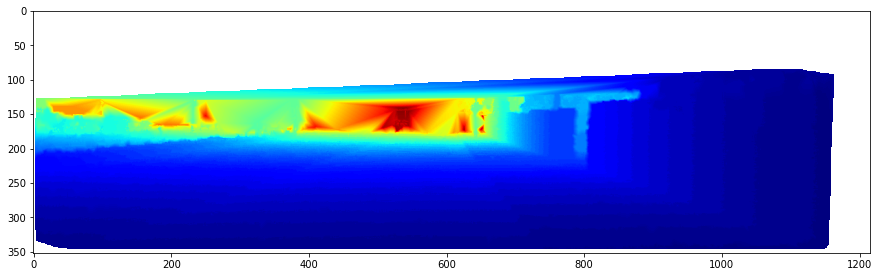

In [102]:
plt.imshow(dense, cmap=cm.jet)

# Todo 28 Sept 


- [ ] Wire mesh plot over
    - coloured image
    - depth image
    - error img
 
- [ ] build new arucore mesh
 
 
- [ ] Change colourmaps
- [ ] error metrics
    - sse
    - inlier threshold?
- [ ]  change MoC to thresholding by default




# Mesh plots

In [ ]:
from scipy.spatial import Delaunay

In [ ]:
pts = maximumOfCurvature(img).T
pts

In [ ]:
pts.shape

In [ ]:
plt.imshow(img)
centers = np.round(np.sum(pts[tri.simplices], axis=1, dtype='int')/3.0).astype(int)
colours = e_img_moc[centers[:,1], centers[:,0]]
# colours = np.nan_to_num(np.round(colours*1000))
colours = np.nan_to_num((e_img_moc[centers[:,1], centers[:,0]]))

# plt.triplot(pts[:,0], pts[:,1], triangles = Delaunay(pts[:,:2]).simplices,)
plt.tripcolor(pts[:,0], pts[:,1], triangles = Delaunay(pts[:,:2]).simplices, facecolors=colours, edgecolors='k', cmap='jet')


In [ ]:
colours**2